# Lecture 6: k-Means Properties & Improvements

In this notebook, we explore:
1. **Initialization Sensitivity**: How bad starts lead to bad clustering.
2. **Random Restarts**: Running multiple times and keeping the best.
3. **k-Means++**: The smarter initialization (default in sklearn).
4. **The Elbow Method**: Choosing $K$.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

%matplotlib inline
np.random.seed(42)

---
## 1. Generate Data

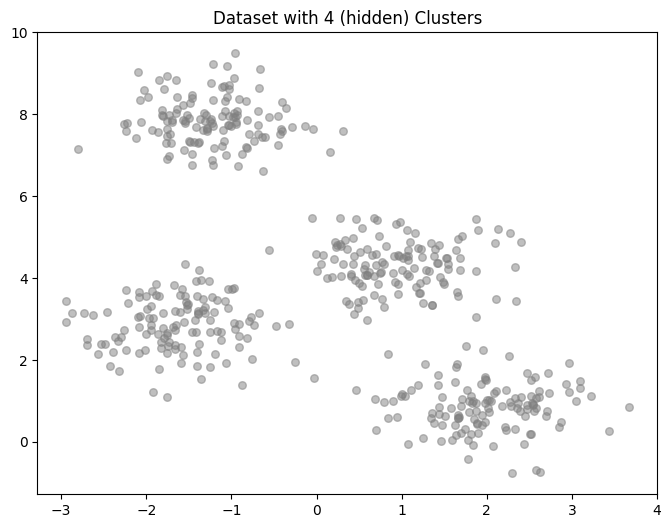

In [17]:
X, y = make_blobs(n_samples=500, centers=4, cluster_std=0.60, random_state=0)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.5, c='gray')
plt.title("Dataset with 4 (hidden) Clusters")
plt.show()

### Using sklearn's KMeans

In Lecture 5, we implemented k-Means from scratch. In practice, we use `sklearn.cluster.KMeans`.

**Basic Usage Pattern:**
```python
from sklearn.cluster import KMeans

# 1. Create the model (specify number of clusters)
model = KMeans(n_clusters=K)

# 2. Fit the model to data
model.fit(X)

# 3. Access results
model.labels_          # Cluster assignment for each point (array of length N)
model.cluster_centers_ # Location of each center (array of shape K x D)
model.inertia_         # WCSS (Within-Cluster Sum of Squares)
```

**Key Parameters:**
| Parameter | Description | Default |
|-----------|-------------|---------|
| `n_clusters` | Number of clusters $K$ | 8 |
| `init` | Initialization method: `'random'` or `'k-means++'` | `'k-means++'` |
| `n_init` | Number of random restarts (keeps best) | 10 |
| `random_state` | Seed for reproducibility | None |

In [18]:
# TODO: Apply k-Means to cluster the dataset X into 4 clusters

### BEGIN SOLUTION
# Create a KMeans model with n_clusters=4
model = KMeans(n_clusters=4)

# Fit the model to X
model.fit(X)

# Print the WCSS and cluster centers shape
print(f"WCSS: {model.inertia_}")
print(f"Cluster centers shape: {model.cluster_centers_.shape}")
### END SOLUTION

WCSS: 345.1797115465465
Cluster centers shape: (4, 2)


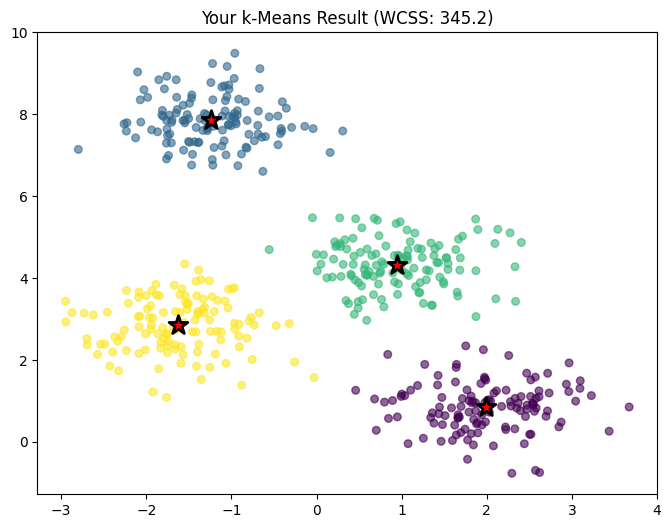

In [19]:
# Visualize your clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=30, cmap='viridis', alpha=0.6)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], 
            c='red', s=200, marker='*', edgecolor='black', linewidth=2)
plt.title(f"Your k-Means Result (WCSS: {model.inertia_:.1f})")
plt.show()

---
## 2. Initialization Sensitivity

k-Means starts by randomly selecting $K$ initial centers. Because the algorithm only finds a **local optimum**, different starting points can lead to very different final clusterings—some good, some bad.

To demonstrate this, we'll run k-Means **6 times** with different random seeds. We use `n_init=1` to disable sklearn's default behavior of running multiple restarts by itself. We will also set `init='random'` to ensure the same random initialization each time (rather than sklearn's default of k-means++).

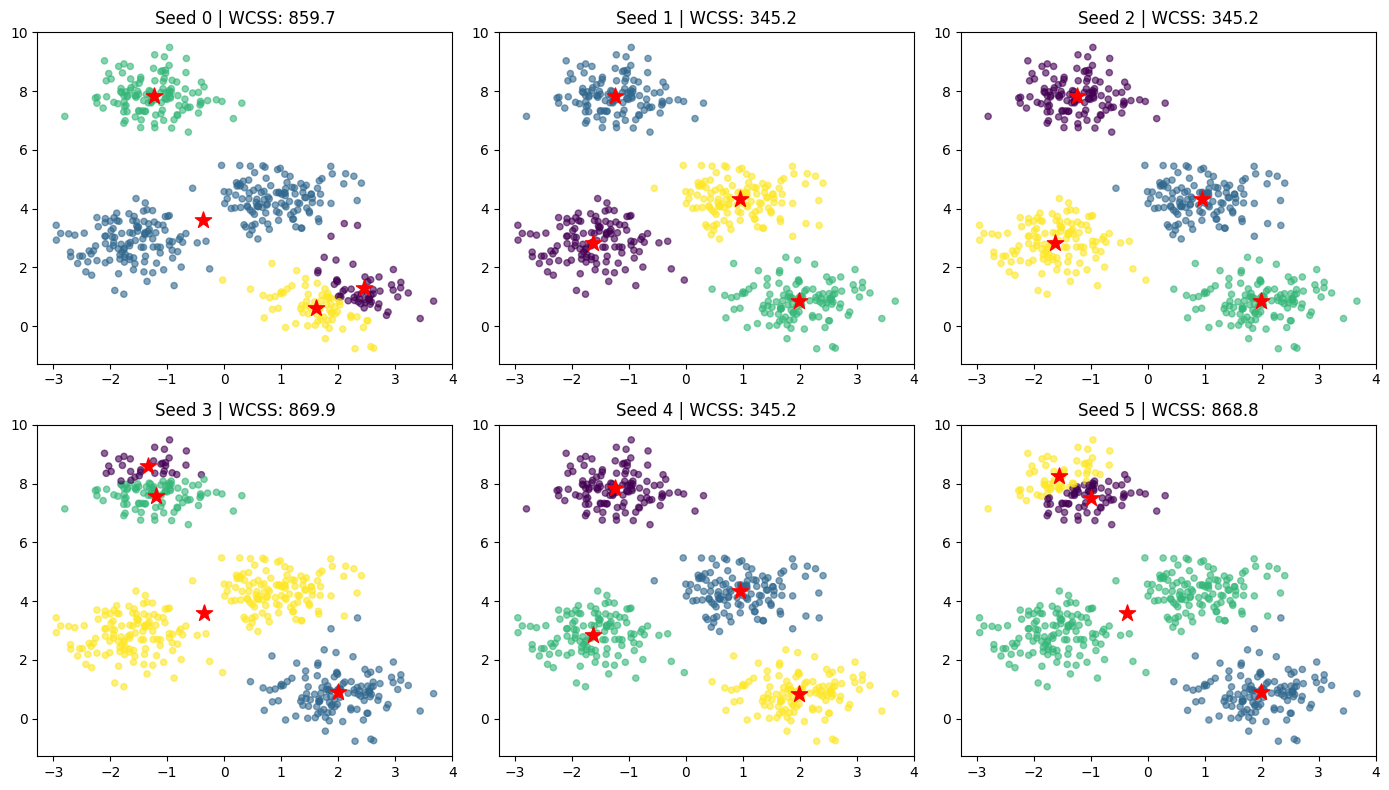


WCSS Range: 345.2 (best) to 869.9 (worst)
Variation: 152.0% difference!


In [20]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

wcss_values = []
for i in range(len(axes)):
    ax = axes[i]
    ### BEGIN SOLUTION
    seed = i 
    kmeans = KMeans(n_clusters=4, init='random', n_init=1, random_state=seed)
    kmeans.fit(X)
    wcss_values.append(kmeans.inertia_)
    ### END SOLUTION
    
    ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, s=20, cmap='viridis', alpha=0.6)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
               c='red', s=150, marker='*')
    ax.set_title(f"Seed {seed} | WCSS: {kmeans.inertia_:.1f}")

plt.tight_layout()
plt.show()

print(f"\nWCSS Range: {min(wcss_values):.1f} (best) to {max(wcss_values):.1f} (worst)")
print(f"Variation: {(max(wcss_values) - min(wcss_values)) / min(wcss_values) * 100:.1f}% difference!")

**Observation:** Different random starts lead to *very* different results. Some seeds get stuck in bad local optima!

---
## 3. Random Restarts

The standard fix: run k-Means multiple times and keep the best result.

In [21]:
# Random restarts: just use n_init parameter
n_restarts = 10
model = KMeans(n_clusters=4, init='random', n_init=n_restarts, random_state=42)
model.fit(X)

print(f"Best WCSS from {n_restarts} restarts: {model.inertia_:.1f}")

Best WCSS from 10 restarts: 345.2


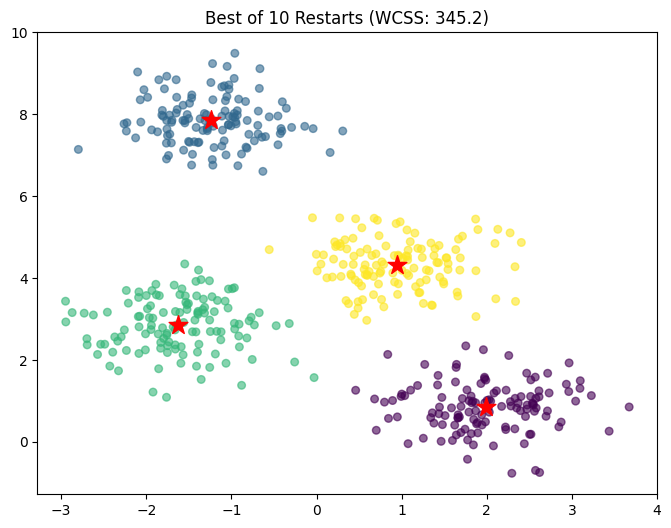

In [22]:
# Visualize the best result
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=30, cmap='viridis', alpha=0.6)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], 
            c='red', s=200, marker='*')
plt.title(f"Best of {n_restarts} Restarts (WCSS: {model.inertia_:.1f})")
plt.show()

---
## 4. k-Means++ Initialization

Instead of picking initial centers completely at random, **k-Means++** spreads them out:
1. Choose the first center randomly from the data points
2. For each subsequent center, pick a point with probability proportional to its squared distance from the nearest existing center

This simple change makes k-Means much more likely to find a good solution on the first try. Scikit-learn uses `init='k-means++'` by default.

Let's compare both initialization methods side-by-side using the same random seed.

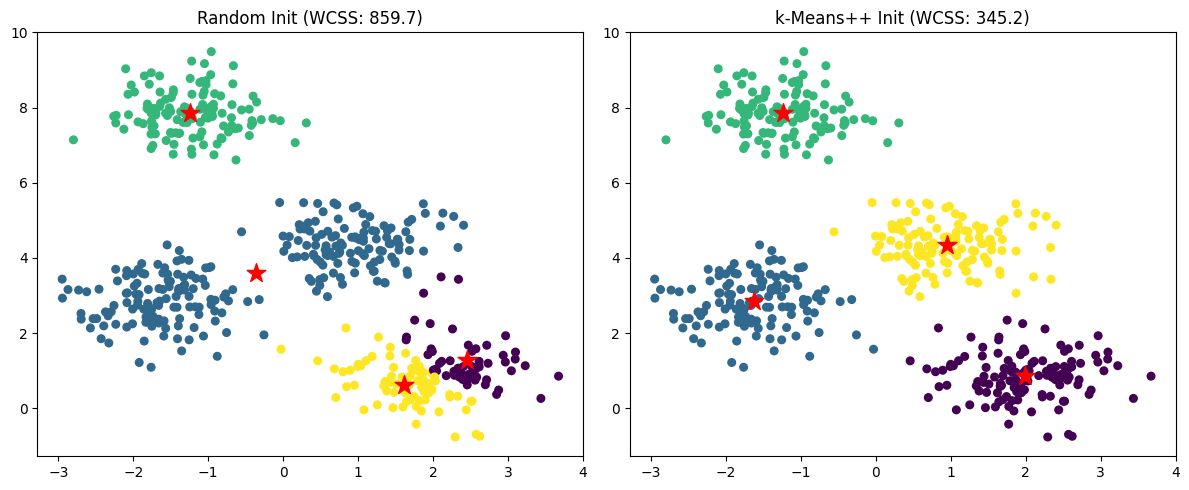

Random init WCSS: 859.7
k-Means++ WCSS:   345.2


In [ ]:
# Compare random vs k-means++ initialization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

### BEGIN SOLUTION
# Random init (single run)
kmeans_random = KMeans(n_clusters=4, init='random', n_init=1, random_state=0)
kmeans_random.fit(X)

# k-means++ init (single run)
kmeans_pp = KMeans(n_clusters=4, init='k-means++', n_init=1, random_state=0)
kmeans_pp.fit(X)
### END SOLUTION

# Plot random init result
axes[0].scatter(X[:, 0], X[:, 1], c=kmeans_random.labels_, s=30, cmap='viridis')
axes[0].scatter(kmeans_random.cluster_centers_[:, 0], kmeans_random.cluster_centers_[:, 1], 
                c='red', s=200, marker='*')
axes[0].set_title(f"Random Init (WCSS: {kmeans_random.inertia_:.1f})")

# Plot k-means++ result
axes[1].scatter(X[:, 0], X[:, 1], c=kmeans_pp.labels_, s=30, cmap='viridis')
axes[1].scatter(kmeans_pp.cluster_centers_[:, 0], kmeans_pp.cluster_centers_[:, 1], 
                c='red', s=200, marker='*')
axes[1].set_title(f"k-Means++ Init (WCSS: {kmeans_pp.inertia_:.1f})")

plt.tight_layout()
plt.show()

print(f"Random init WCSS: {kmeans_random.inertia_:.1f}")
print(f"k-Means++ WCSS:   {kmeans_pp.inertia_:.1f}")

**k-Means++ usually gives better results, even with a single run!**

---
## 5. The Elbow Method

How do we choose $K$ when we don't know the true number of clusters? 

**Key insight:** As $K$ increases, WCSS always decreases (more clusters = points closer to centers). But at some point, adding more clusters gives diminishing returns.

The **Elbow Method**:
1. Run k-Means for $K = 1, 2, 3, \ldots$
2. Plot WCSS vs $K$
3. Look for the "elbow"—where the curve bends and WCSS stops dropping sharply

In [ ]:
# TODO: Compute WCSS for K=1 to K=10 and store in wcss_values

### BEGIN SOLUTION
k_values = range(1, 11)
wcss_values = []

for k in k_values:
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    model.fit(X)
    wcss_values.append(model.inertia_)
### END SOLUTION

# Print results
for k, wcss in zip(k_values, wcss_values):
    print(f"K={k}: WCSS = {wcss:.1f}")

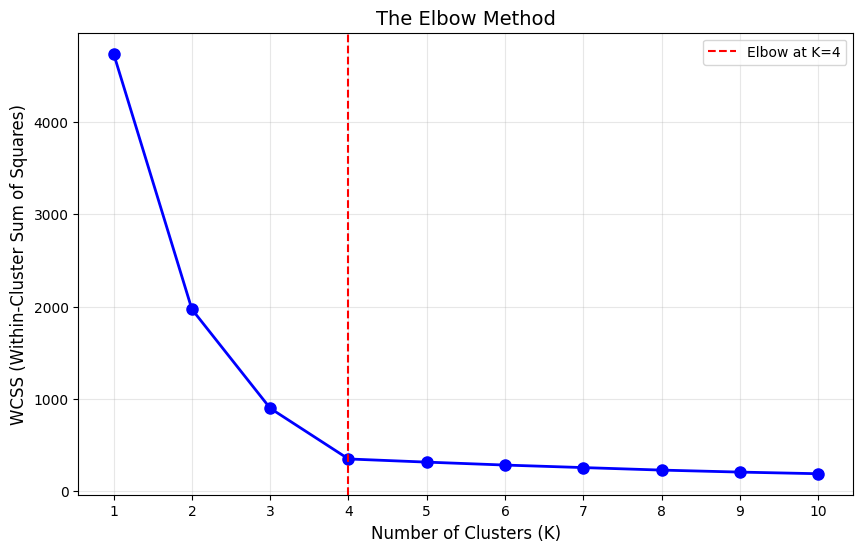

In [25]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('The Elbow Method', fontsize=14)
plt.xticks(k_values)
plt.grid(True, alpha=0.3)

# Highlight the elbow (at K=4, which we know is correct)
plt.axvline(x=4, color='red', linestyle='--', label='Elbow at K=4')
plt.legend()
plt.show()

**The elbow is at K=4**, which matches the true number of clusters in our data!